# Postprocess adjoint model output

In [1]:
import numpy as np
from matplotlib import pyplot as plt
#from matplotlib import cm, colors
#%matplotlib inline
import xgcm
import xmitgcm
#import cartopy as cart
#import cartopy.crs as ccrs
#import cartopy.feature as cf
import ecco_v4_py as ecco
import xarray as xr

from llcmap import *

## Load the grid

In [2]:
grid_dir = 'datasets/grids/llc90/'

In [3]:
ds = xmitgcm.open_mdsdataset(grid_dir,iters=None,geometry='llc')

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/xmitgcm/mds_store.py:837: UserWarning: Couldn't find available_diagnostics.log in datasets/grids/llc90/ or datasets/grids/llc90/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


In [4]:
# to use ecco_v4_py functions:
ds = ds.rename({'face':'tile'})

## Plot cell area

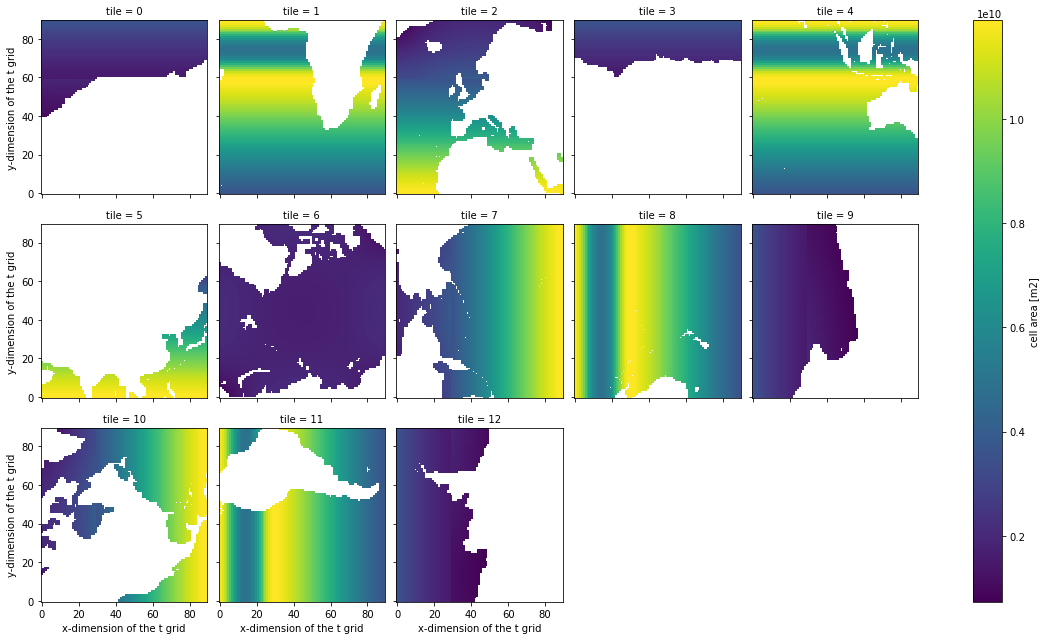

In [5]:
ds.rA.where(ds.maskC.isel(k=0)).plot(col='tile',col_wrap=5) #mask where land to avoid values area = 0
#ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,1*ds.maskC.isel(k=0))
#equivalently: ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,ds.maskC.isel(k=0).astype(float))

## Read accumulated (5-year mean) sensitivities & divide by cell area

In [6]:
def read_adxx_acc(fdir,fname,nrecs):
    array = ecco.read_llc_to_tiles(fdir,fname,90,0,nrecs,less_output=True)
    return ecco.llc_tiles_to_xda(array,var_type='c') #'c': cell-centered sensitivities

In [7]:
ds1 = ds.copy()
data_dir = '../mitgcm_analysis/MITgcm_c65u/NL_runs/UQmod/'

In [8]:
exp = 'thetaIrm300m'
exp_dir = 'run_AVG5yboxIrminger'

#cost function was multiplied by 1e+7 to be numerically more stable
#divide by grid cell area

ds1[exp + '_adxx_taux']=1e-7*read_adxx_acc(data_dir+exp_dir+'/ADXXfiles',
                                    fname='Acc_adxx_SICTRLtauu_61.data',nrecs=1)/ds1.rA.where(ds1.maskC.isel(k=0))
ds1[exp + '_adxx_tauy']=1e-7*read_adxx_acc(data_dir+exp_dir+'/ADXXfiles',
                                    fname='Acc_adxx_SICTRLtauv_61.data',nrecs=1)/ds1.rA.where(ds1.maskC.isel(k=0))

ds1[exp + '_adxx_taux'].attrs = {'units' : 'degC/N', 
                                'description': 'Sensitivity of 5-year mean Irminger Sea temperature at 300m ' + 
                                                'to changes in 5-year mean zonal wind stress'}
ds1[exp + '_adxx_tauy'].attrs = {'units' : 'degC/N',
                                'description': 'Sensitivity of 5-year mean Irminger Sea temperature at 300m ' + 
                                                'to changes in 5-year mean meridional wind stress'}

In [9]:
exp = 'heatISR'
exp_dir = 'run_AVG5yheatISR'

#divide by grid cell area

ds1[exp + '_adxx_taux']=read_adxx_acc(data_dir+exp_dir+'/ADXXfiles',
                               fname='Acc_adxx_SICTRLtauu_61.data',nrecs=1)/ds1.rA.where(ds1.maskC.isel(k=0))
ds1[exp + '_adxx_tauy']=read_adxx_acc(data_dir+exp_dir+'/ADXXfiles',
                               fname='Acc_adxx_SICTRLtauv_61.data',nrecs=1)/ds1.rA.where(ds1.maskC.isel(k=0))

ds1[exp + '_adxx_taux'].attrs = {'units' : 'W/N', 
                                'description': 'Sensitivity of 5-year mean heat transport across the ' +
                                                'Iceland-Scotland ridge ' +
                                                'to changes in 5-year mean zonal wind stress'}
ds1[exp + '_adxx_tauy'].attrs = {'units' : 'W/N',
                                'description': 'Sensitivity of 5-year mean heat transport across the ' +
                                                'Iceland-Scotland ridge ' +
                                                'to changes in 5-year mean meridional wind stress'}

In [10]:
exp = 'heatOSNAPe'
exp_dir = 'run_AVG5yheatOSNAPe'

#divide by grid cell area

ds1[exp + '_adxx_taux']=read_adxx_acc(data_dir+exp_dir+'/ADXXfiles',
                               fname='Acc_adxx_SICTRLtauu_61.data',nrecs=1)/ds1.rA.where(ds1.maskC.isel(k=0))
ds1[exp + '_adxx_tauy']=read_adxx_acc(data_dir+exp_dir+'/ADXXfiles',
                               fname='Acc_adxx_SICTRLtauv_61.data',nrecs=1)/ds1.rA.where(ds1.maskC.isel(k=0))

ds1[exp + '_adxx_taux'].attrs = {'units' : 'W/N', 
                                'description': 'Sensitivity of 5-year mean heat transport across the ' +
                                                'OSNAP-East section ' +
                                                'to changes in 5-year mean zonal wind stress'}
ds1[exp + '_adxx_tauy'].attrs = {'units' : 'W/N',
                                'description': 'Sensitivity of 5-year mean heat transport across the ' +
                                                'OSNAP-East section ' +
                                                'to changes in 5-year mean meridional wind stress'}

## Plot the sensitivities

In [11]:
mapper = atlantic_map(ds1)
#plt.rcParams.update({'text.usetex':False})

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/colors.py:1026: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


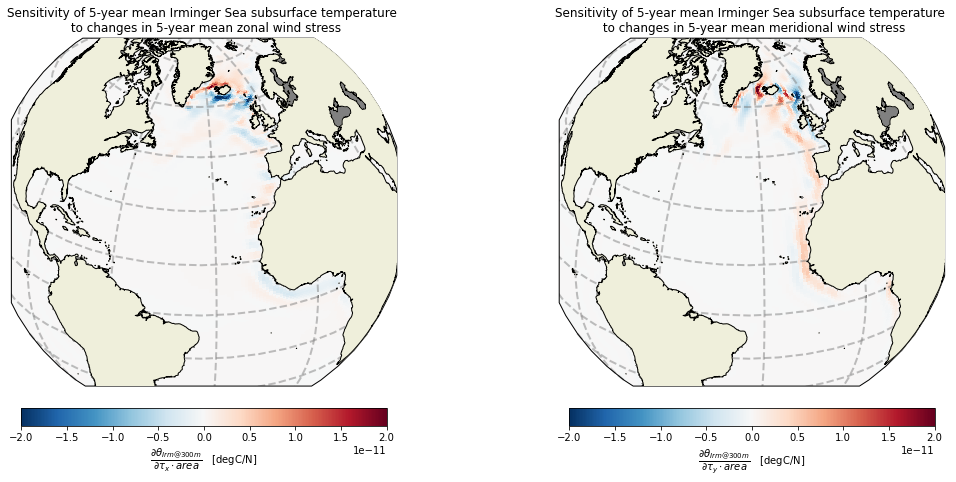

In [12]:
exp = 'thetaIrm300m'
qoi = 'Irminger Sea subsurface temperature'
qoi_label = 'theta_{Irm@300m}'
vmax = 2e-11

fig,axs = plt.subplots(1,2,figsize=(18,8),
                      subplot_kw={'projection':ccrs.Orthographic(central_longitude=-35,central_latitude=30)})

mapper(ds1[exp + '_adxx_taux'], vmin=-vmax, vmax=vmax, cmap='RdBu_r', 
        cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_x \cdot area}\quad$'% qoi_label 
                   + '[' + ds1[exp + '_adxx_taux'].units + ']', 
        ax=axs[0])
mapper(ds1[exp + '_adxx_tauy'], vmin=-vmax, vmax=vmax, cmap='RdBu_r',
       cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_y \cdot area}\quad$' % qoi_label
                  + '[' + ds1[exp + '_adxx_tauy'].units + ']', 
       ax=axs[1])

axs[0].set_title('Sensitivity of 5-year mean %s \n to changes in 5-year mean zonal wind stress' %qoi);
axs[1].set_title('Sensitivity of 5-year mean %s \n to changes in 5-year mean meridional wind stress' %qoi);

In [13]:
# a different way to do the same thing:
#exp = 'thetaIrm300m'

#fig = plt.figure(figsize=(18,8))
#vmax = 2e-11
#fig,ax0,p0,cbar0,*_=ecco.plot_proj_to_latlon_grid(ds1.XC,ds1.YC,
#                                               ds1[exp + '_adxx_taux'],
#                                               show_colorbar=False,
#                                               projection_type='ortho',
#                                               user_lat_0=30,
#                                               user_lon_0=-35,
#                                               cmin=-vmax,cmax=vmax,
#                                               show_grid_lines=False,
#                                               subplot_grid=[1,2,1])
#fig,ax1,p1,cbar1,*_=ecco.plot_proj_to_latlon_grid(ds1.XC,ds1.YC,
#                                               ds1[exp + '_adxx_tauy'],
#                                               show_colorbar=False,
#                                               projection_type='ortho',
#                                               user_lat_0=30,
#                                               user_lon_0=-35,
#                                               cmin=-vmax,cmax=vmax,
#                                               show_grid_lines=False,
#                                               subplot_grid=[1,2,2])
#axs = [ax0,ax1]
#for ax,p,lbl in zip(axs,[p0,p1],['tau_x','tau_y']):
#    ax.add_feature(cf.LAND,zorder=200,color='gray')
#    ax.gridlines(crs=ccrs.PlateCarree(),linewidth=1,color='lightgray',alpha=1,linestyle=':',zorder=100)
#    
#
#    fig.colorbar(p,ax=ax,orientation='horizontal',
#                 label=r'$\dfrac{\partial\theta_{Irm@300m}}{\partial \%s \cdot area} \left[\dfrac{^\circ C}{N}\right]$' % lbl,extend='both')#

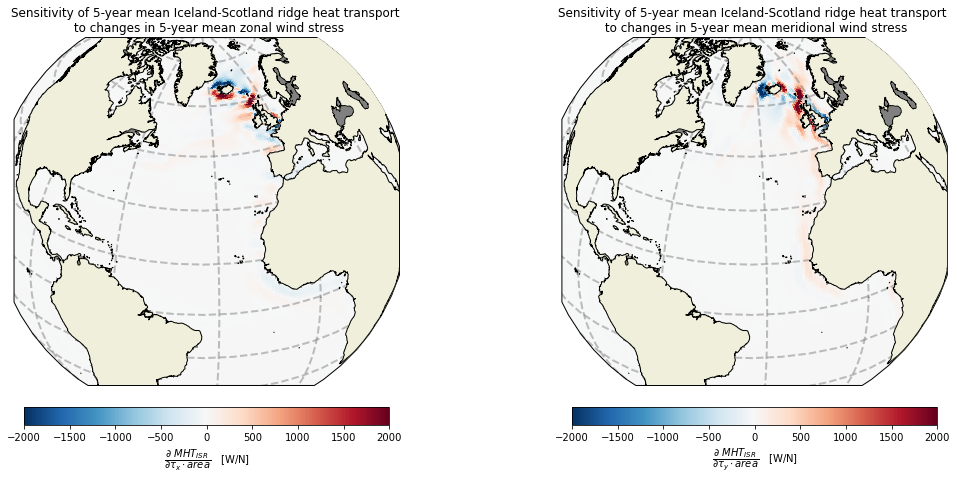

In [14]:
exp = 'heatISR'
qoi = 'Iceland-Scotland ridge heat transport'
qoi_label = ' MHT_{ISR}'
vmax = 2000

fig,axs = plt.subplots(1,2,figsize=(18,8),
                      subplot_kw={'projection':ccrs.Orthographic(central_longitude=-35,central_latitude=30)})

mapper(ds1[exp + '_adxx_taux'], vmin=-vmax, vmax=vmax, cmap='RdBu_r', 
        cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_x \cdot area}\quad$'% qoi_label 
                   + '[' + ds1[exp + '_adxx_taux'].units + ']', 
        ax=axs[0])
mapper(ds1[exp + '_adxx_tauy'], vmin=-vmax, vmax=vmax, cmap='RdBu_r',
       cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_y \cdot area}\quad$' % qoi_label
                  + '[' + ds1[exp + '_adxx_tauy'].units + ']', 
       ax=axs[1])

axs[0].set_title('Sensitivity of 5-year mean %s \n to changes in 5-year mean zonal wind stress' %qoi);
axs[1].set_title('Sensitivity of 5-year mean %s \n to changes in 5-year mean meridional wind stress' %qoi);

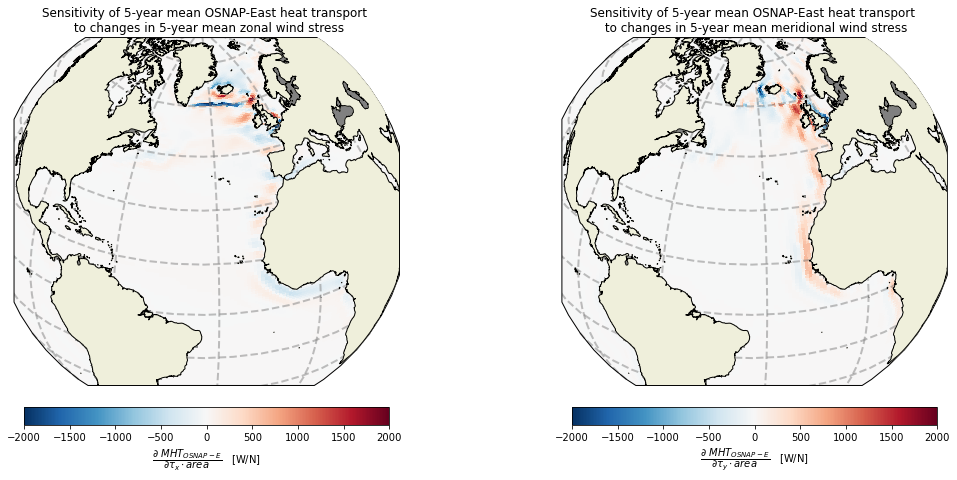

In [15]:
exp = 'heatOSNAPe'
qoi = 'OSNAP-East heat transport'
qoi_label = ' MHT_{OSNAP-E}'
vmax = 2000

fig,axs = plt.subplots(1,2,figsize=(18,8),
                      subplot_kw={'projection':ccrs.Orthographic(central_longitude=-35,central_latitude=30)})

mapper(ds1[exp + '_adxx_taux'], vmin=-vmax, vmax=vmax, cmap='RdBu_r', 
        cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_x \cdot area}\quad$'% qoi_label 
                   + '[' + ds1[exp + '_adxx_taux'].units + ']', 
        ax=axs[0])
mapper(ds1[exp + '_adxx_tauy'], vmin=-vmax, vmax=vmax, cmap='RdBu_r',
       cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_y \cdot area}\quad$' % qoi_label
                  + '[' + ds1[exp + '_adxx_tauy'].units + ']', 
       ax=axs[1])

axs[0].set_title('Sensitivity of 5-year mean %s \n to changes in 5-year mean zonal wind stress' %qoi);
axs[1].set_title('Sensitivity of 5-year mean %s \n to changes in 5-year mean meridional wind stress' %qoi);

## Add more attributes to dataset & save to netcdf

In [16]:
ds1.attrs = {'description': 'adjoint sensitivities computed from ECCOv4r2 2007-2011', 'author': 'Nora Loose'}


In [17]:
ds1.to_netcdf('datasets/NA_sens5yr_native.nc')
# To open this: xarray.open_dataset(filename)

## Interpolate to lat lon grid 

In [18]:
from ecco_v4_py import resample_to_latlon

In [19]:
dy = .25
dx = .25

In [20]:
exp = 'thetaIrm300m'

lons,lats,adxx_taux = resample_to_latlon(ds1.XC,ds1.YC,ds1[exp + '_adxx_taux'],
                                      -90+dy, 90-dy, dy, -180+dx, 180-dx, dx, mapping_method='nearest_neighbor',
                                      radius_of_influence=100000)
lons,lats,adxx_tauy = resample_to_latlon(ds1.XC,ds1.YC,ds1[exp + '_adxx_tauy'],
                                      -90+dy, 90-dy, dy, -180+dx, 180-dx, dx, mapping_method='nearest_neighbor',
                                      radius_of_influence=100000)

In [21]:
xlons = xr.DataArray(lons[0,:],coords={'lon':lons[0,:]},dims=('lon',),
                     name='lon',attrs={'units':'Degrees East','full_name':'longitude'})
xlats = xr.DataArray(lats[:,0],coords={'lat':lats[:,0]},dims=('lat',),
                     name='lat',attrs={'units':'Degrees North','full_name':'latitude'})

In [22]:
ll = xr.Dataset()
ll['lon'] = xlons
ll['lat'] = xlats

In [23]:
exp = 'thetaIrm300m'

ll[exp + '_adxx_taux'] = xr.DataArray(adxx_taux,coords={'lat':ll.lat,'lon':ll.lon},dims=('lat','lon'))
ll[exp + '_adxx_tauy'] = xr.DataArray(adxx_tauy,coords={'lat':ll.lat,'lon':ll.lon},dims=('lat','lon'))

ll[exp + '_adxx_taux'].attrs = ds1[exp + '_adxx_taux'].attrs
ll[exp + '_adxx_tauy'].attrs = ds1[exp + '_adxx_tauy'].attrs


In [24]:
expList = ['heatISR','heatOSNAPe']

for exp in expList:

    lons,lats,adxx_taux = resample_to_latlon(ds1.XC,ds1.YC,ds1[exp + '_adxx_taux'],
                                      -90+dy, 90-dy, dy, -180+dx, 180-dx, dx, mapping_method='nearest_neighbor',
                                      radius_of_influence=100000)
    lons,lats,adxx_tauy = resample_to_latlon(ds1.XC,ds1.YC,ds1[exp + '_adxx_tauy'],
                                      -90+dy, 90-dy, dy, -180+dx, 180-dx, dx, mapping_method='nearest_neighbor',
                                      radius_of_influence=100000)

    ll[exp + '_adxx_taux'] = xr.DataArray(adxx_taux,coords={'lat':ll.lat,'lon':ll.lon},dims=('lat','lon'))
    ll[exp + '_adxx_tauy'] = xr.DataArray(adxx_tauy,coords={'lat':ll.lat,'lon':ll.lon},dims=('lat','lon'))

    ll[exp + '_adxx_taux'].attrs = ds1[exp + '_adxx_taux'].attrs
    ll[exp + '_adxx_tauy'].attrs = ds1[exp + '_adxx_tauy'].attrs

## Plot interpolated fields & compare to original ones

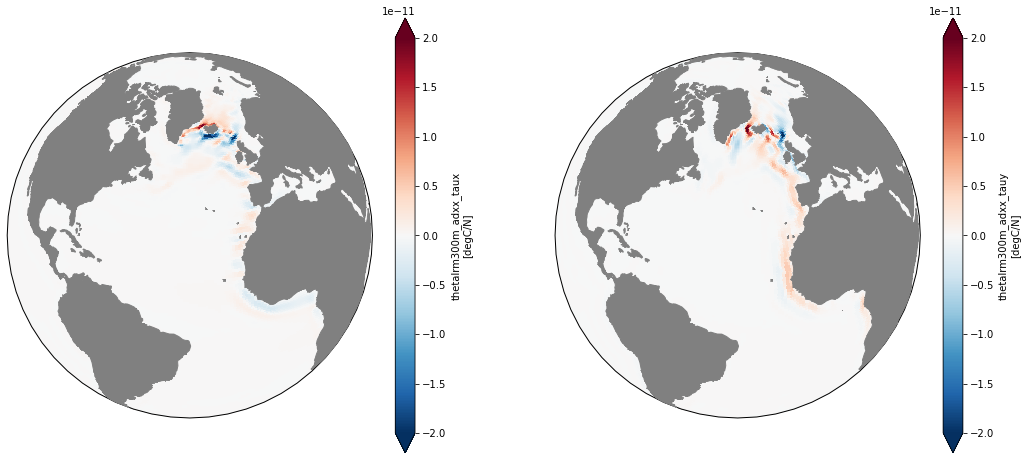

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/colors.py:1026: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


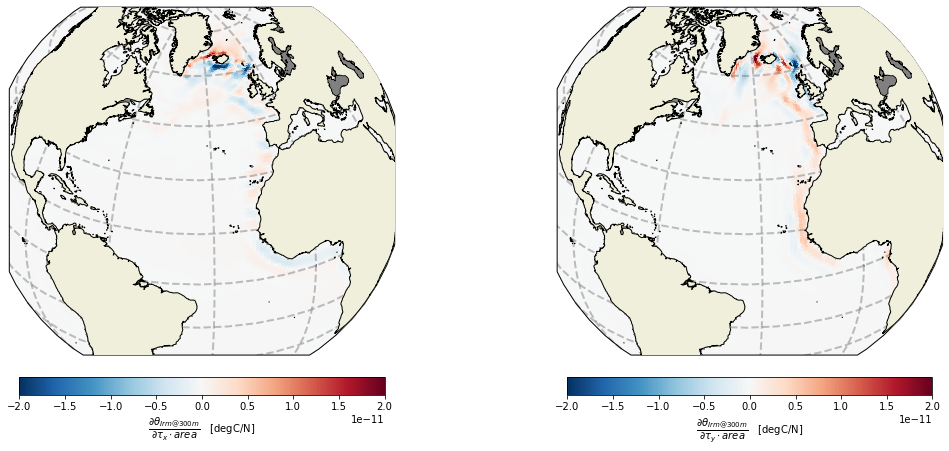

In [54]:
exp = 'thetaIrm300m'
vmax = 2e-11
qoi_label = 'theta_{Irm@300m}'

fig,axs = plt.subplots(1,2,figsize=(18,8),
                      subplot_kw={'projection':ccrs.Orthographic(central_longitude=-35,central_latitude=30)})

ll[exp + '_adxx_taux'].plot(vmin=-vmax,vmax=vmax,cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0),ax=axs[0])

ll[exp + '_adxx_tauy'].plot(vmin=-vmax,vmax=vmax,cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0),ax=axs[1])
[ax.add_feature(cf.LAND,zorder=3,color='gray') for ax in axs]


fig,axs = plt.subplots(1,2,figsize=(18,8),
                      subplot_kw={'projection':ccrs.Orthographic(central_longitude=-35,central_latitude=30)})

mapper(ds1[exp + '_adxx_taux'], vmin=-vmax, vmax=vmax, cmap='RdBu_r', 
        cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_x \cdot area}\quad$'% qoi_label 
                   + '[' + ds1[exp + '_adxx_taux'].units + ']', 
        ax=axs[0])
mapper(ds1[exp + '_adxx_tauy'], vmin=-vmax, vmax=vmax, cmap='RdBu_r',
       cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_y \cdot area}\quad$' % qoi_label
                  + '[' + ds1[exp + '_adxx_tauy'].units + ']', 
       ax=axs[1])


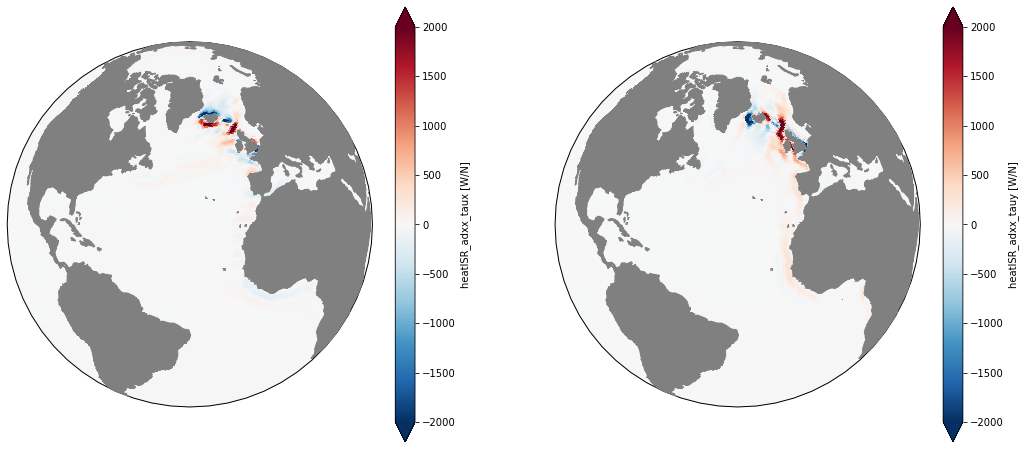

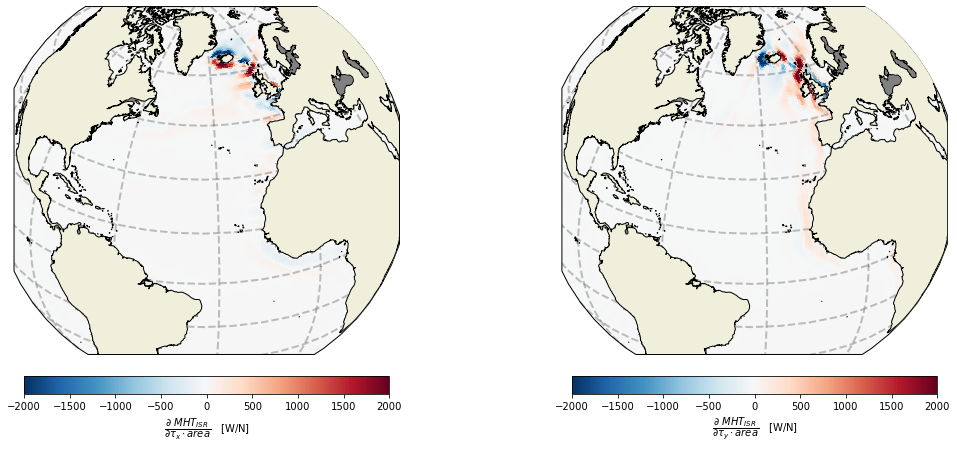

In [55]:
exp = 'heatISR'
vmax = 2000
qoi_label = ' MHT_{ISR}'

fig,axs = plt.subplots(1,2,figsize=(18,8),
                      subplot_kw={'projection':ccrs.Orthographic(central_longitude=-35,central_latitude=30)})

ll[exp + '_adxx_taux'].plot(vmin=-vmax,vmax=vmax,cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0),ax=axs[0])

ll[exp + '_adxx_tauy'].plot(vmin=-vmax,vmax=vmax,cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0),ax=axs[1])
[ax.add_feature(cf.LAND,zorder=3,color='gray') for ax in axs]


fig,axs = plt.subplots(1,2,figsize=(18,8),
                      subplot_kw={'projection':ccrs.Orthographic(central_longitude=-35,central_latitude=30)})

mapper(ds1[exp + '_adxx_taux'], vmin=-vmax, vmax=vmax, cmap='RdBu_r', 
        cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_x \cdot area}\quad$'% qoi_label 
                   + '[' + ds1[exp + '_adxx_taux'].units + ']', 
        ax=axs[0])
mapper(ds1[exp + '_adxx_tauy'], vmin=-vmax, vmax=vmax, cmap='RdBu_r',
       cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_y \cdot area}\quad$' % qoi_label
                  + '[' + ds1[exp + '_adxx_tauy'].units + ']', 
       ax=axs[1])

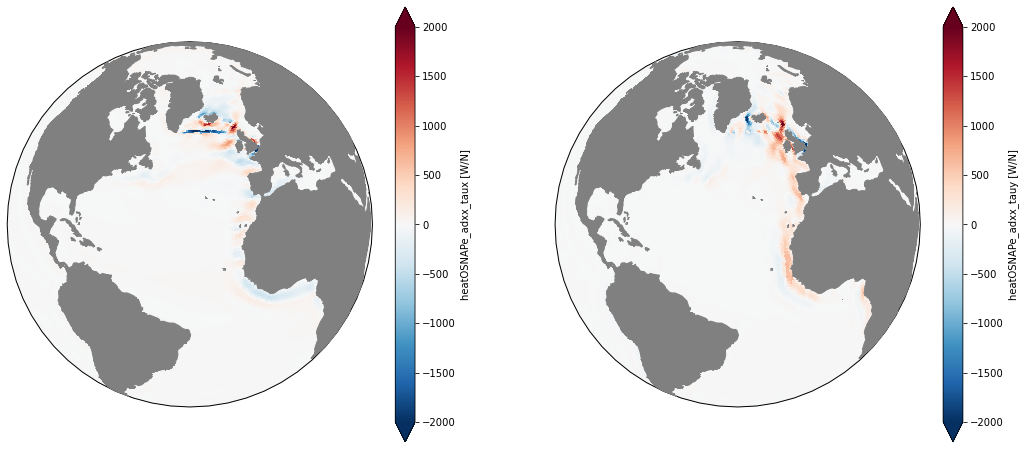

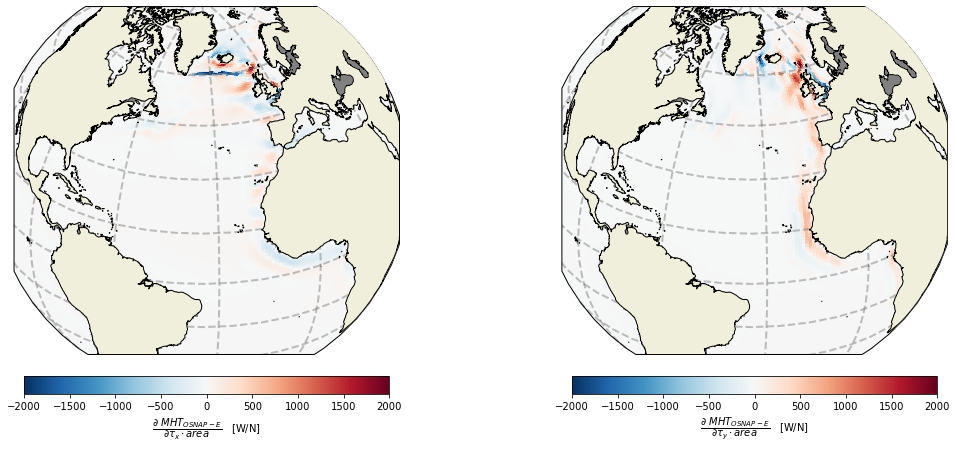

In [56]:
exp = 'heatOSNAPe'
vmax = 2000
qoi_label = ' MHT_{OSNAP-E}'

fig,axs = plt.subplots(1,2,figsize=(18,8),
                      subplot_kw={'projection':ccrs.Orthographic(central_longitude=-35,central_latitude=30)})

ll[exp + '_adxx_taux'].plot(vmin=-vmax,vmax=vmax,cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0),ax=axs[0])

ll[exp + '_adxx_tauy'].plot(vmin=-vmax,vmax=vmax,cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0),ax=axs[1])
[ax.add_feature(cf.LAND,zorder=3,color='gray') for ax in axs]


fig,axs = plt.subplots(1,2,figsize=(18,8),
                      subplot_kw={'projection':ccrs.Orthographic(central_longitude=-35,central_latitude=30)})

mapper(ds1[exp + '_adxx_taux'], vmin=-vmax, vmax=vmax, cmap='RdBu_r', 
        cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_x \cdot area}\quad$'% qoi_label 
                   + '[' + ds1[exp + '_adxx_taux'].units + ']', 
        ax=axs[0])
mapper(ds1[exp + '_adxx_tauy'], vmin=-vmax, vmax=vmax, cmap='RdBu_r',
       cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_y \cdot area}\quad$' % qoi_label
                  + '[' + ds1[exp + '_adxx_tauy'].units + ']', 
       ax=axs[1])

In [28]:
ll.to_netcdf('datasets/NA_sens5yr_latlon.nc')

## Read monthly mean sensitivities

In [29]:
def read_adxx(fdir,fname,nrecs):
    array = ecco.read_llc_to_tiles(fdir,fname,90,0,nrecs,less_output=True)
    return ecco.llc_tiles_to_xda(array,var_type='c',dim4='time') #'c': cell-centered sensitivities

In [30]:
ds2 = ds.copy()
ds2.attrs = {'description': 'adjoint sensitivities computed from ECCOv4r3 2005-2010', 'author': 'Nora Loose'}
data_dir = '../mitgcm_analysis/OSNAP/'

In [31]:
exp_dir = 'runr3_horflux_thetaOSNAPeast_Mar2010'
exp = 'heatOSNAPe'
fac = 1
nrecs = 61

ds2[exp + '_adxx_taux']= fac*read_adxx(data_dir+exp_dir+'/mat',
                                    fname='adxx_SICTRLtauu_61.data',nrecs=nrecs)/ds2.rA.where(ds2.maskC.isel(k=0))
ds2[exp + '_adxx_tauy']= fac*read_adxx(data_dir+exp_dir+'/mat',
                                    fname='adxx_SICTRLtauv_61.data',nrecs=nrecs)/ds2.rA.where(ds2.maskC.isel(k=0))
    
ds2[exp + '_adxx_taux'].attrs = {'units' : 'degC/N', 
                                'description': 'Sensitivity of March Irminger Sea temperature at 300m ' + 
                                                'to changes in zonal wind stress at decreasing lead times'}
ds2[exp + '_adxx_tauy'].attrs = {'units' : 'degC/N',
                                'description': 'Sensitivity of March Irminger Sea temperature at 300m ' + 
                                                'to changes in meridional wind stress at decreasing lead times'}

In [32]:
# drop last record, whose values are all 0
ds2 = ds2.drop_sel(time=60)

In [33]:
ds2
#ds2.heatOSNAPe_adxx_taux.isel(time=59).plot(col='tile',col_wrap=5)

<xarray.Dataset>
Dimensions:               (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, tile: 13, time: 60)
Coordinates:
  * i                     (i) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i_g                   (i_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * j                     (j) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * j_g                   (j_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * k                     (k) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * k_u                   (k_u) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * k_l                   (k_l) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * k_p1                  (k_p1) int64 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * tile                  (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC                    (tile, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    YC                    (tile, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    XG                    (tile, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    YG                    (tile, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    CS                    (tile, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    SN                    (tile, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    Z                     (k) >f4 -5.0 -15.0 -25.0 ... -5461.25 -5906.25
    Zp1                   (k_p1) >f4 0.0 -10.0 -20.0 ... -5244.5 -5678.0 -6134.5
    Zu                    (k_u) >f4 -10.0 -20.0 -30.0 ... -5678.0 -6134.5
    Zl                    (k_l) >f4 0.0 -10.0 -20.0 ... -4834.0 -5244.5 -5678.0
    rA                    (tile, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dxG                   (tile, j_g, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dyG                   (tile, j, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    Depth                 (tile, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rAz                   (tile, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dxC                   (tile, j, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dyC                   (tile, j_g, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rAw                   (tile, j, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rAs                   (tile, j_g, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    drC                   (k_p1) >f4 5.0 10.0 10.0 10.0 ... 422.0 445.0 228.25
    drF                   (k) >f4 10.0 10.0 10.0 10.0 ... 410.5 433.5 456.5
    PHrefC                (k) >f4 49.05 147.15 245.25 ... 53574.863 57940.312
    PHrefF                (k_p1) >f4 0.0 98.1 196.2 ... 55701.18 60179.445
    hFacC                 (k, tile, j, i) >f4 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    hFacW                 (k, tile, j, i_g) >f4 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    hFacS                 (k, tile, j_g, i) >f4 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    maskC                 (k, tile, j, i) bool dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    maskW                 (k, tile, j, i_g) bool dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    maskS                 (k, tile, j_g, i) bool dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    maskCtrlS             (k, tile, j_g, i) bool dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    maskCtrlW             (k, tile, j, i_g) bool dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    maskCtrlC             (k, tile, j, i) bool dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
  * time                  (time) int64 0 1 2 3 4 5 6 7 ... 53 54 55 56 57 58 59
Data variables:
    heatOSNAPe_adxx_taux  (time, tile, j, i) float64 dask.array<chunksize=(60, 1, 90, 90

In [34]:
from datetime import datetime, timedelta

In [35]:
my_iter_list = range(59,-1,-1)
my_iter_list

range(59, -1, -1)

In [36]:
#my_date_list = [datetime(year=2010,month=3,day=15,hour=12) - timedelta(days=30.5*x) for x in my_iter_list ]
my_date_list = [-timedelta(days=30.5*x) for x in my_iter_list ]

In [37]:
adj_time = np.array(my_date_list)

In [38]:
#ds2['adj_time'] = xr.DataArray(adj_time,coords={'time':ds2.time},dims=('time',))
ds2['adj_time'] = xr.DataArray(adj_time,coords=ds2.time.coords,dims=ds2.time.dims)

In [39]:
ds2 = ds2.set_coords('adj_time')

In [40]:
ds2 = ds2.swap_dims({'time':'adj_time'})
#ds2 = ds2.drop('time')

In [41]:
ds2

<xarray.Dataset>
Dimensions:               (adj_time: 60, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, tile: 13)
Coordinates:
  * i                     (i) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i_g                   (i_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * j                     (j) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * j_g                   (j_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * k                     (k) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * k_u                   (k_u) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * k_l                   (k_l) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * k_p1                  (k_p1) int64 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * tile                  (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC                    (tile, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    YC                    (tile, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    XG                    (tile, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    YG                    (tile, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    CS                    (tile, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    SN                    (tile, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    Z                     (k) >f4 -5.0 -15.0 -25.0 ... -5461.25 -5906.25
    Zp1                   (k_p1) >f4 0.0 -10.0 -20.0 ... -5244.5 -5678.0 -6134.5
    Zu                    (k_u) >f4 -10.0 -20.0 -30.0 ... -5678.0 -6134.5
    Zl                    (k_l) >f4 0.0 -10.0 -20.0 ... -4834.0 -5244.5 -5678.0
    rA                    (tile, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dxG                   (tile, j_g, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dyG                   (tile, j, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    Depth                 (tile, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rAz                   (tile, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dxC                   (tile, j, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dyC                   (tile, j_g, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rAw                   (tile, j, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rAs                   (tile, j_g, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    drC                   (k_p1) >f4 5.0 10.0 10.0 10.0 ... 422.0 445.0 228.25
    drF                   (k) >f4 10.0 10.0 10.0 10.0 ... 410.5 433.5 456.5
    PHrefC                (k) >f4 49.05 147.15 245.25 ... 53574.863 57940.312
    PHrefF                (k_p1) >f4 0.0 98.1 196.2 ... 55701.18 60179.445
    hFacC                 (k, tile, j, i) >f4 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    hFacW                 (k, tile, j, i_g) >f4 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    hFacS                 (k, tile, j_g, i) >f4 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    maskC                 (k, tile, j, i) bool dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    maskW                 (k, tile, j, i_g) bool dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    maskS                 (k, tile, j_g, i) bool dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    maskCtrlS             (k, tile, j_g, i) bool dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    maskCtrlW             (k, tile, j, i_g) bool dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    maskCtrlC             (k, tile, j, i) bool dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    time                  (adj_time) int64 0 1 2 3 4 5 6 ... 54 55 56 57 58 59
  * adj_time              (adj_time) timedelta64[ns] -1800 days +12:00:00 ... 0 days 00:00:00
Data va

In [42]:
ds2['adj_time'].attrs = {'description': 'Forcing lead time'}

## Plot sensitivities at different lead times

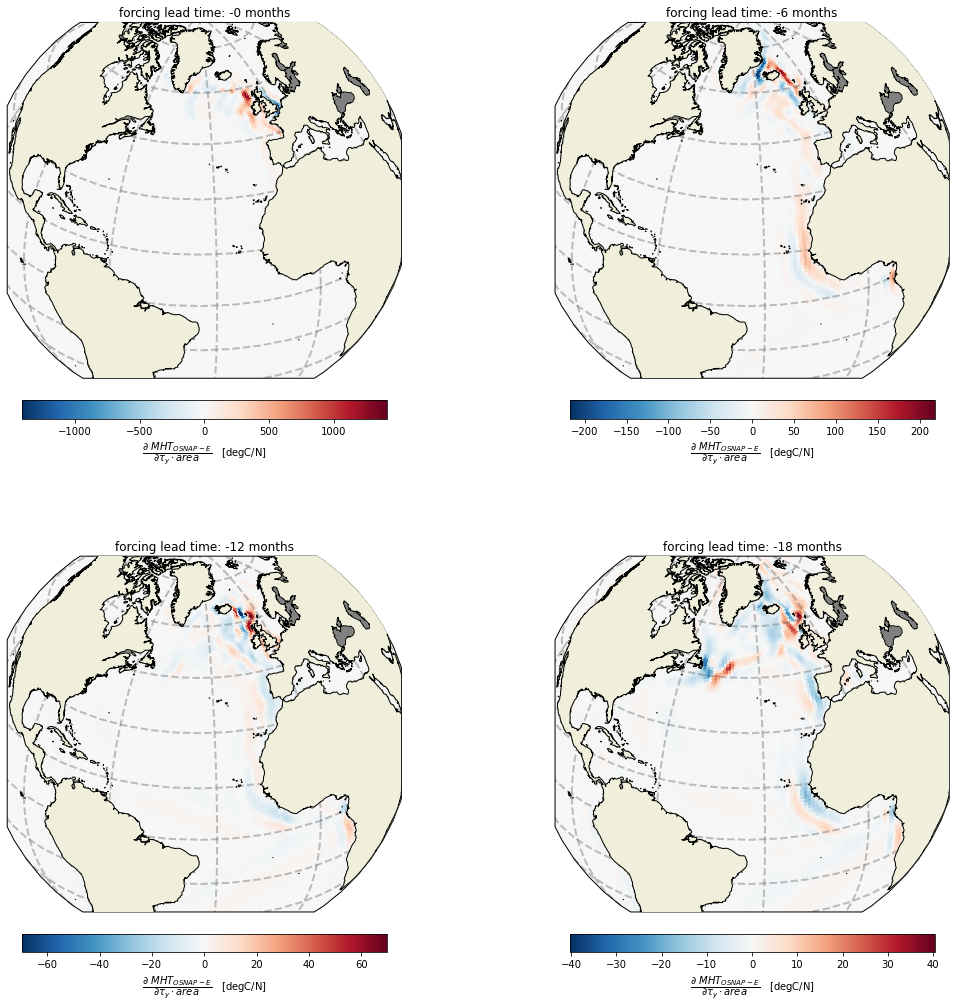

In [43]:
exp = 'heatOSNAPe'
qoi = 'OSNAP-East heat transport'
qoi_label = ' MHT_{OSNAP-E}'

fig,axs = plt.subplots(2,2,figsize=(18,18),
                      subplot_kw={'projection':ccrs.Orthographic(central_longitude=-35,central_latitude=30)})

mapper(ds2.heatOSNAPe_adxx_tauy.isel(adj_time=59), cmap='RdBu_r', 
        cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_y \cdot area}\quad$'% qoi_label 
                   + '[' + ds2[exp + '_adxx_tauy'].units + ']', 
        ax=axs[0,0])

mapper(ds2.heatOSNAPe_adxx_tauy.isel(adj_time=53), cmap='RdBu_r',
       cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_y \cdot area}\quad$' % qoi_label
                  + '[' + ds2[exp + '_adxx_tauy'].units + ']', 
       ax=axs[0,1])

mapper(ds2.heatOSNAPe_adxx_tauy.isel(adj_time=47), cmap='RdBu_r',
       cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_y \cdot area}\quad$' % qoi_label
                  + '[' + ds2[exp + '_adxx_tauy'].units + ']', 
       ax=axs[1,0])

mapper(ds2.heatOSNAPe_adxx_tauy.isel(adj_time=41), cmap='RdBu_r',
       cbar_label=r'$\dfrac{\partial \%s}{\partial \tau_y \cdot area}\quad$' % qoi_label
                  + '[' + ds2[exp + '_adxx_tauy'].units + ']', 
       ax=axs[1,1])

axs[0,0].set_title('forcing lead time: -0 months');
axs[0,1].set_title('forcing lead time: -6 months');
axs[1,0].set_title('forcing lead time: -12 months');
axs[1,1].set_title('forcing lead time: -18 months');
#axs[1].set_title('Sensitivity of March %s to changes in \n meridional wind stress at a lead time of 6 month' %qoi);

In [44]:
ds2.to_netcdf('datasets/NA_sensMonthly_native.nc')
# To open this: xarray.open_dataset(filename)

## Interpolate to lat lon grid

In [45]:
dy = .25
dx = .25

In [46]:
exp = 'heatOSNAPe'

ll2 = xr.Dataset()


lons,lats,_ = resample_to_latlon(ds2.XC,ds2.YC,ds2.heatOSNAPe_adxx_taux.isel(adj_time=0),
                                      -90+dy, 90-dy, dy, -180+dx, 180-dx, dx, mapping_method='nearest_neighbor',
                                      radius_of_influence=100000)

xlons = xr.DataArray(lons[0,:],coords={'lon':lons[0,:]},dims=('lon',),
                     name='lon',attrs={'units':'Degrees East','full_name':'longitude'})
xlats = xr.DataArray(lats[:,0],coords={'lat':lats[:,0]},dims=('lat',),
                     name='lat',attrs={'units':'Degrees North','full_name':'latitude'})

ll2['lon'] = xlons
ll2['lat'] = xlats
ll2['heatOSNAPe_adxx_taux'] = xr.zeros_like(ds2.time*xlats*xlons)
ll2['heatOSNAPe_adxx_tauy'] = xr.zeros_like(ds2.time*xlats*xlons)

ll2

<xarray.Dataset>
Dimensions:               (adj_time: 60, lat: 719, lon: 1439)
Coordinates:
  * lon                   (lon) float64 -179.8 -179.5 -179.2 ... 179.5 179.8
  * lat                   (lat) float64 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
    time                  (adj_time) int64 0 1 2 3 4 5 6 ... 54 55 56 57 58 59
  * adj_time              (adj_time) timedelta64[ns] -1800 days +12:00:00 ... 0 days 00:00:00
Data variables:
    heatOSNAPe_adxx_taux  (adj_time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    heatOSNAPe_adxx_tauy  (adj_time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0

In [47]:
for itime in range(60):
    mytime = ds2.adj_time.isel(adj_time=itime)
    _,_,adxx_taux = resample_to_latlon(ds2.XC,ds2.YC,ds2.heatOSNAPe_adxx_taux.sel(adj_time=mytime),
                                      -90+dy, 90-dy, dy, -180+dx, 180-dx, dx, mapping_method='nearest_neighbor',
                                      radius_of_influence=100000)
    _,_,adxx_tauy = resample_to_latlon(ds2.XC,ds2.YC,ds2.heatOSNAPe_adxx_tauy.sel(adj_time=mytime),
                                      -90+dy, 90-dy, dy, -180+dx, 180-dx, dx, mapping_method='nearest_neighbor',
                                      radius_of_influence=100000)

    ll2['heatOSNAPe_adxx_taux'].loc[{'adj_time':mytime}] = xr.DataArray(adxx_taux,coords={'lat':ll2.lat,'lon':ll2.lon},dims=('lat','lon'))
    ll2['heatOSNAPe_adxx_tauy'].loc[{'adj_time':mytime}] = xr.DataArray(adxx_tauy,coords={'lat':ll2.lat,'lon':ll2.lon},dims=('lat','lon'))

ll2[exp + '_adxx_taux'].attrs = ds2[exp + '_adxx_taux'].attrs
ll2[exp + '_adxx_tauy'].attrs = ds2[exp + '_adxx_tauy'].attrs

## Plot interpolated fields & compare to original ones

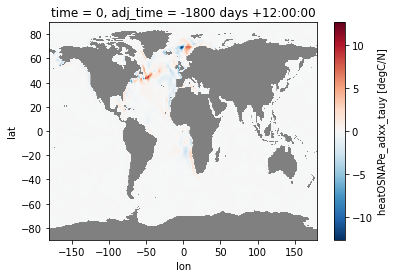

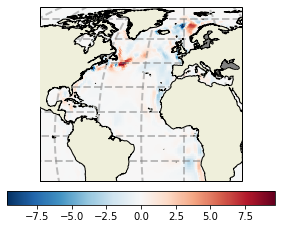

In [48]:
ll2.heatOSNAPe_adxx_tauy.isel(adj_time=0).plot()
mapper(ds2.heatOSNAPe_adxx_tauy.isel(adj_time=0), cmap='RdBu_r')

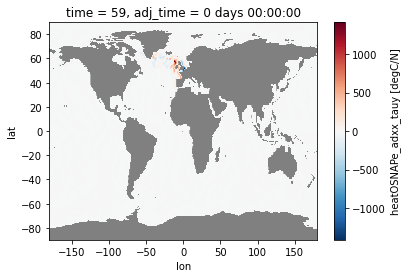

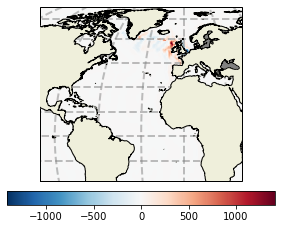

In [49]:
ll2.heatOSNAPe_adxx_tauy.isel(adj_time=59).plot()
mapper(ds2.heatOSNAPe_adxx_tauy.isel(adj_time=59), cmap='RdBu_r')

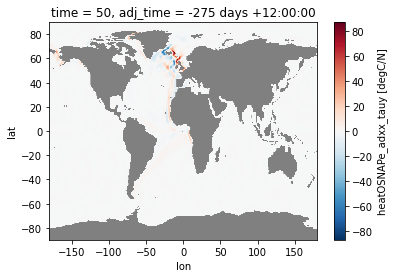

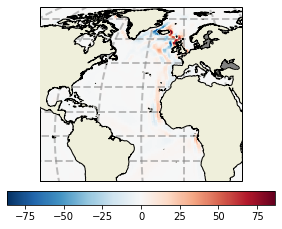

In [50]:
ll2.heatOSNAPe_adxx_tauy.isel(adj_time=50).plot()
mapper(ds2.heatOSNAPe_adxx_tauy.isel(adj_time=50), cmap='RdBu_r')

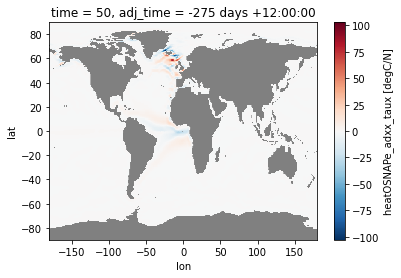

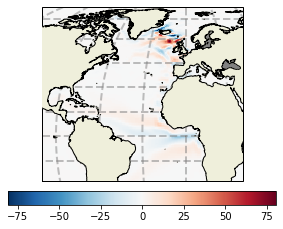

In [51]:
ll2.heatOSNAPe_adxx_taux.isel(adj_time=50).plot()
mapper(ds2.heatOSNAPe_adxx_taux.isel(adj_time=50), cmap='RdBu_r')

In [52]:
ll2.to_netcdf('datasets/NA_sensMonthly_latlon.nc')